In [50]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import interpolate
from importlib import reload
from sklearn import preprocessing

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotly.offline as go_offline
import plotly.graph_objects as go

# local import
sys.path.append("../")
from utils.trackmate import dataEngineering as _tm
from utils.visualization import generalPlots as _gplot
from utils.visualization import vectorPlots as _vplot
from utils.trackmate import spatialAnalysis as _stat
from utils.trackmate import woundHealing as _wh

In [2]:
"""Load Data
"""
dir_path = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/WH03/outputs/D3/"

data = _tm.load_trackmate_dir(dir_path)
df = _tm.merge_tracks_and_all(data)
df = _tm.clean_up_trackSpots(df)
print(df.shape)

df.head()

(53356, 66)


,Label_x,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,LINEARITY_OF_FORWARD_PROGRESSION,TOTAL_ABSOLUTE_ANGLE_XY,TOTAL_ABSOLUTE_ANGLE_YZ,TOTAL_ABSOLUTE_ANGLE_ZX,STEP,NORMED_STEP,MEAN_INTENSITY01_SCALED,MEAN_INTENSITY02_SCALED,MEAN_INTENSITY03_SCALED,MEAN_INTENSITY_SCALED
269,ID16890,16890,0,151.274,439.258,484.240,0,0,0,3.5,...,0.159,-1.957,3.142,-1.571,0,0.000000,0.950449,0.000000,1.000000,1.000000
2665,ID16241,16241,0,127.354,438.797,484.634,0,1800,1,3.5,...,0.159,-1.957,3.142,-1.571,1,0.000015,0.654988,0.969980,0.895375,0.895375
3705,ID5538,5538,0,93.415,438.783,484.887,0,3600,2,3.5,...,0.159,-1.957,3.142,-1.571,2,0.000030,0.490973,0.000000,0.723707,0.723707
4769,ID15213,15213,0,61.661,437.684,482.406,0,5400,3,3.5,...,0.159,-1.957,3.142,-1.571,3,0.000045,0.178950,0.000000,0.540787,0.540787
6861,ID16285,16285,0,74.968,437.216,469.729,0,7200,4,3.5,...,0.159,-1.957,3.142,-1.571,4,0.000060,0.982296,0.725359,0.549835,0.549835


In [3]:
# list(df.columns)

Text(0.5, 1.0, 'Cell Cycle Reporters During Wound Healing')

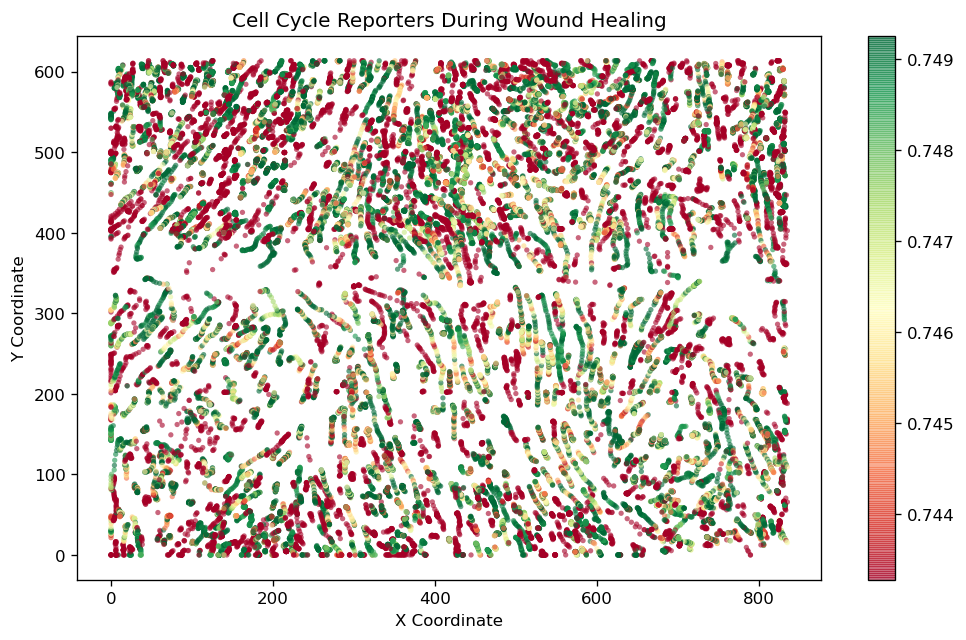

In [49]:
reload(_tm)
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['figure.figsize'] = (15, 12)

df['GREEN_PROP'] = df['MEAN_INTENSITY01'] / (df['MEAN_INTENSITY01'] + df['MEAN_INTENSITY02'])


df = _tm.min_max_norm(df, 'GREEN_PROP', 'TRACK_ID')

matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.dpi'] = 120

plt.clf()

for track in df['TRACK_ID'].unique():
    
    tmp = df[df['TRACK_ID'] == track]
    sc = plt.scatter(tmp['POSITION_X'], 
                     tmp['POSITION_Y'], 
                     c=tmp['GREEN_PROP'], 
                     s=10,
                     edgecolor='none', 
                     cmap='RdYlGn',
                     alpha=0.6)
plt.colorbar(sc)
plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.title("Cell Cycle Reporters During Wound Healing")

Text(0.5, 1.0, 'Wound Healing Migration Patterns')

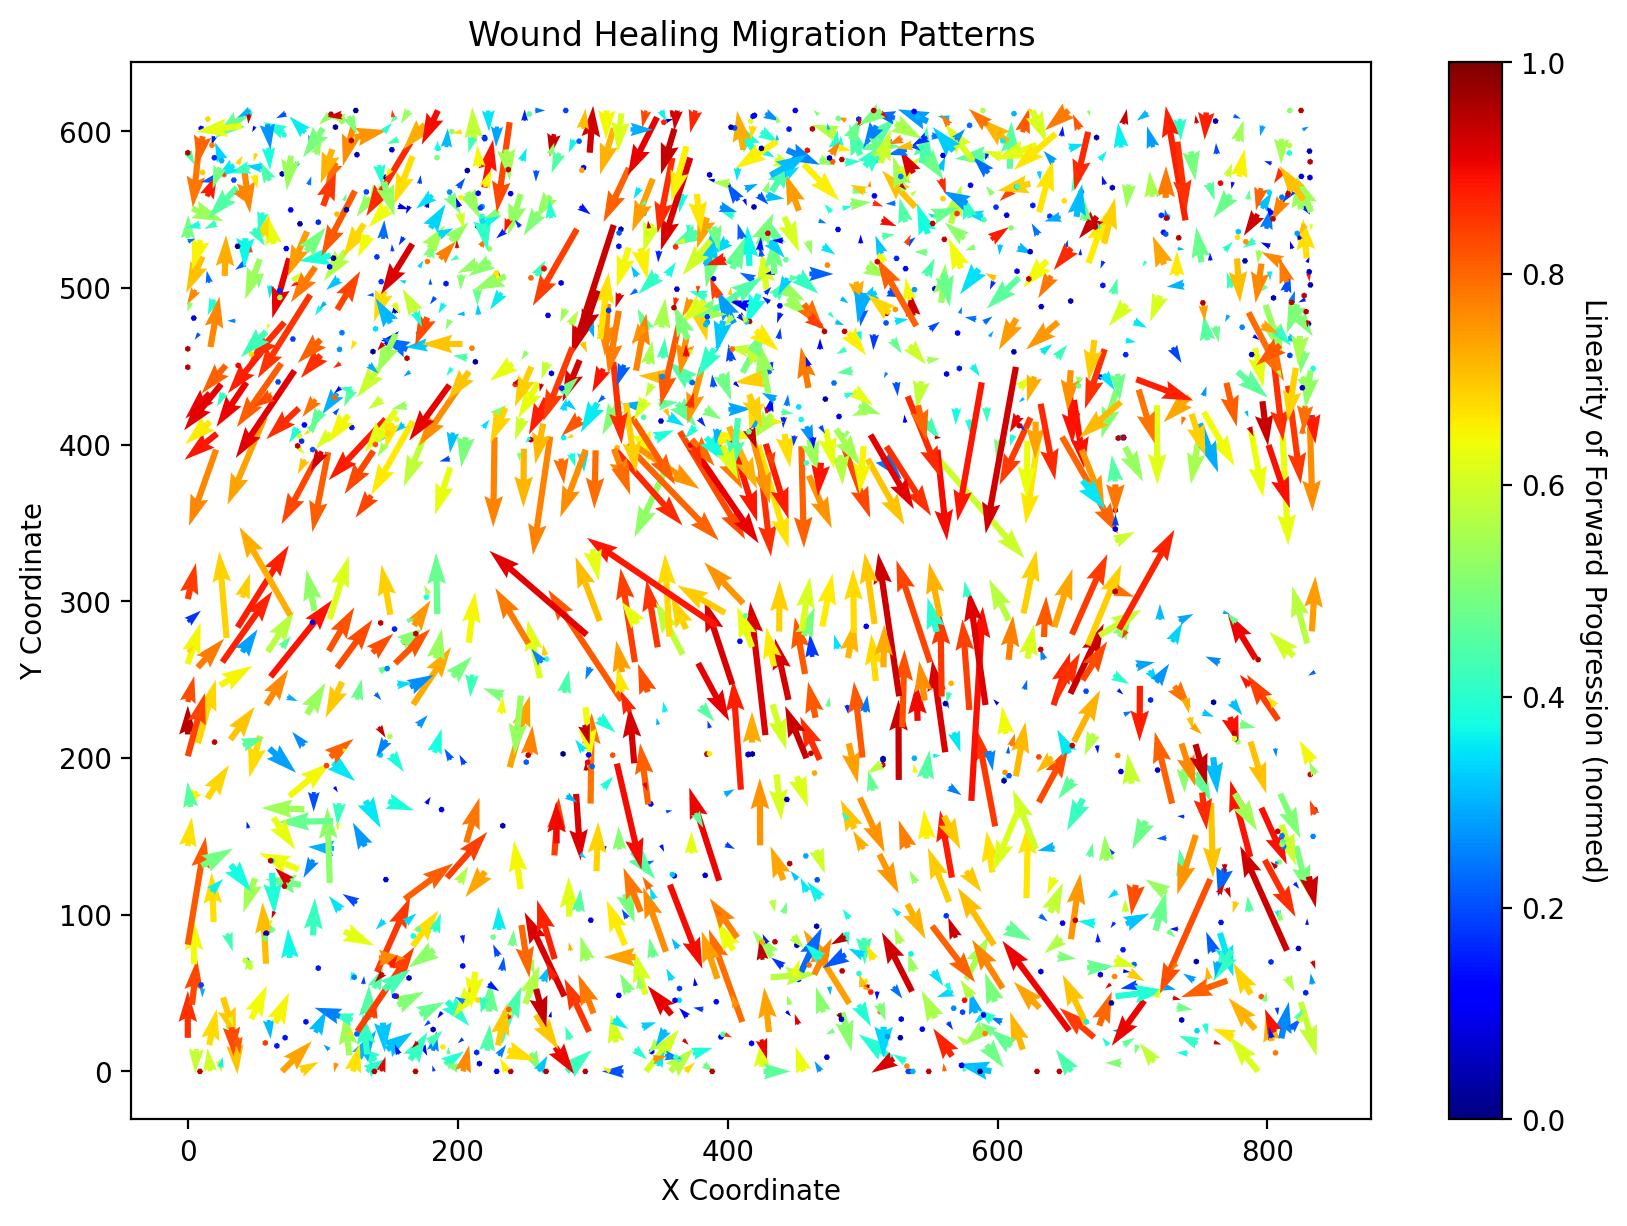

In [5]:
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (10, 7)

q = _vplot.plot_quiver(df, 'TRACK_ID', 'LINEARITY_OF_FORWARD_PROGRESSION')
    
cb = plt.colorbar(q, aspect=20)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('Linearity of Forward Progression (normed)', rotation=270)

plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.title("Wound Healing Migration Patterns")

/home/cstansbu/.local/lib/python3.8/site-packages/pointpats/centrography.py:229: RuntimeWarning:

Mean of empty slice.

/home/cstansbu/.local/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning:

invalid value encountered in true_divide

/home/cstansbu/.local/lib/python3.8/site-packages/pointpats/centrography.py:230: RuntimeWarning:

invalid value encountered in true_divide



Text(0.5, 0.8, 'Cell Initial and Final Densities')

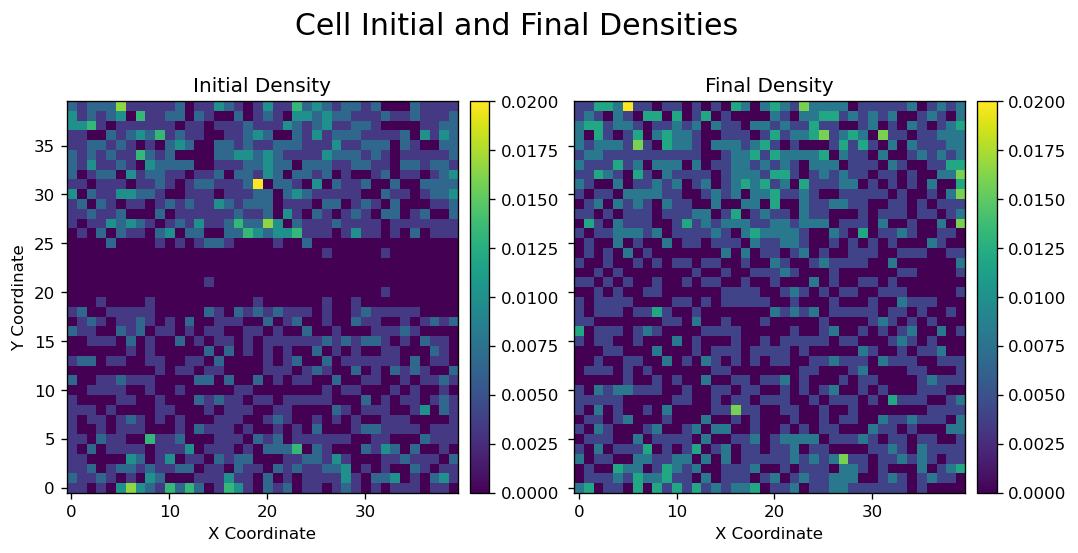

In [6]:
SIZE = 40
FRAME_SIZE = (df['POSITION_X'].max(), df['POSITION_Y'].max())
FRAME_1 = 1
FRAME_2 = 36

frame1 = df[df['FRAME'] == FRAME_1]
frame2 = df[df['FRAME'] == FRAME_2]

dens1, _ = _stat.get_densities(points=frame1[['POSITION_X', 'POSITION_Y']], 
                       frame_size=FRAME_SIZE, 
                       subregion_div=(SIZE, SIZE))

dens2, _ = _stat.get_densities(points=frame2[['POSITION_X', 'POSITION_Y']], 
                       frame_size=FRAME_SIZE, 
                       subregion_div=(SIZE, SIZE))


matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (10, 8)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

im1=ax1.imshow(dens1, interpolation='nearest', cmap='viridis', origin='lower')
ax1.set_title("Initial Density")
ax1.set_ylabel("Y Coordinate")
ax1.set_xlabel("X Coordinate")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax)


im2=ax2.imshow(dens2, interpolation='nearest', cmap='viridis', origin='lower')
ax2.set_title("Final Density")
ax2.set_xlabel("X Coordinate")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax)


plt.suptitle(f"Cell Initial and Final Densities", fontsize=18, y=0.8)

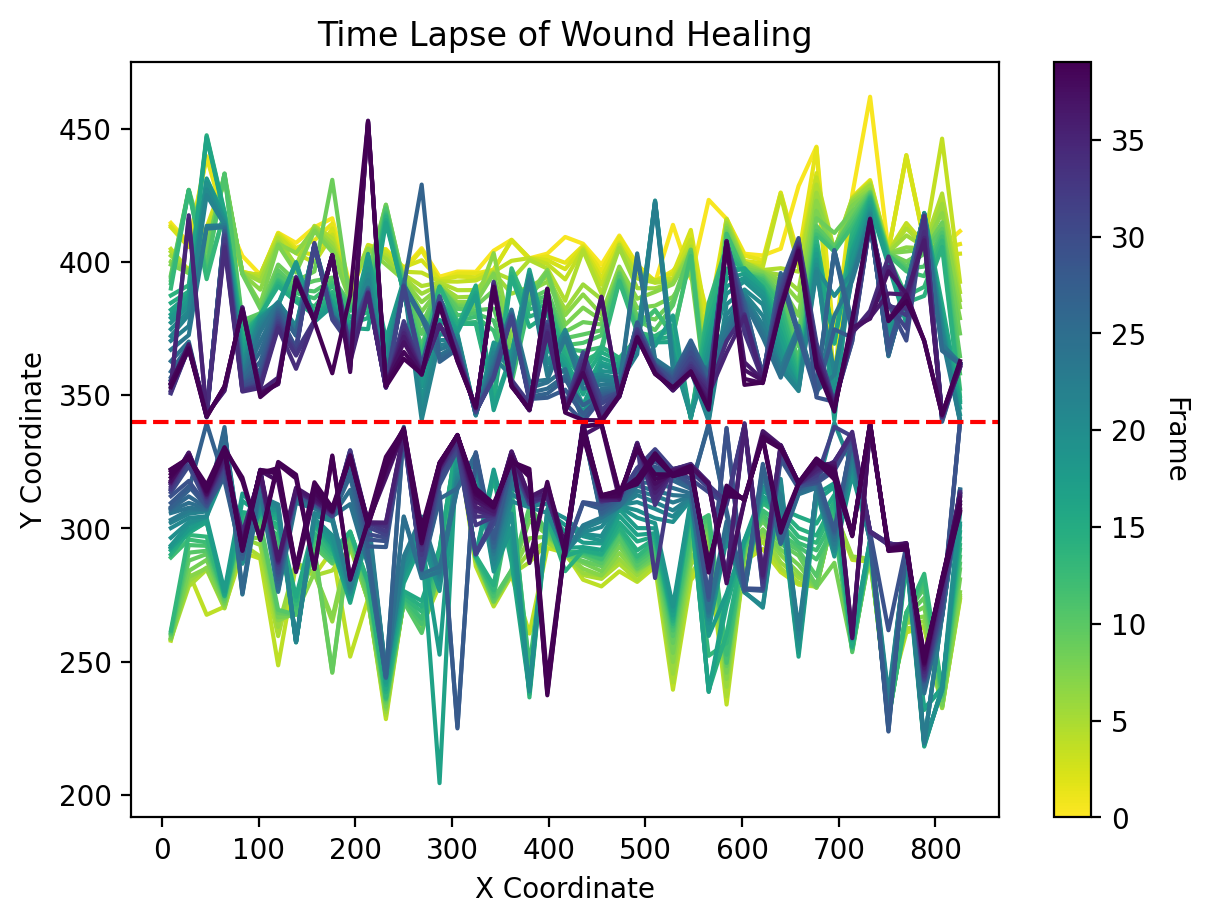

In [14]:
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['patch.facecolor'] = 'white'


cmap = cm.viridis_r
norm = Normalize(vmin=0, vmax=1)

CENTER = 340 
N_BOXES = 45

box = _wh.get_leading_cells(df, CENTER, N_BOXES)

a_list = []
for t in box['FRAME'].unique():

    upper = box[(box['FRAME'] == t) & (box['type'] == 'upper')]
    a = upper['FRAME_NORM'].unique()[0] + 0.01
    plt.plot(upper['POSITION_X'], 
             upper['POSITION_Y'],
             c=cmap(norm(a)))
    
    lower = box[(box['FRAME'] == t) & (box['type'] == 'lower')]
    a = lower['FRAME_NORM'].unique()[0] + 0.1
    plt.plot(lower['POSITION_X'],
             lower['POSITION_Y'],
             c=cmap(norm(a)))
    
    a_list.append(norm(a))
    
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=39))
cb = plt.colorbar(sm, aspect=20)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('Frame', rotation=270)

plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.title("Time Lapse of Wound Healing")


plt.axhline(y=CENTER, color='r', ls='--')

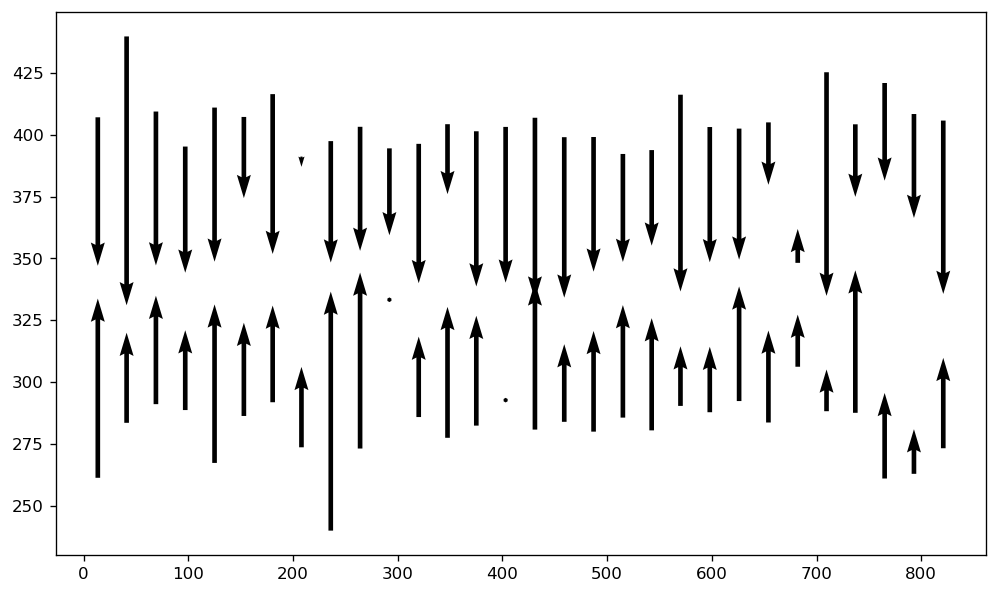

In [82]:
CENTER = 340 
N_BOXES = 30

box = _wh.get_leading_cells(df, CENTER, N_BOXES)

first_last = box[(box['FRAME'] == 0) | (box['FRAME'] == box['FRAME'].max())]

X = []
Y = []
U = []
V = []
C = []

for b in range(N_BOXES):
    tmp = first_last[first_last['BOX'].astype(int) == b+1]
    
    # lower box
    init = (tmp['type'] == 'lower') &  (tmp['FRAME'] == 0)
    fin =  (tmp['type'] == 'lower') &  (tmp['FRAME'] == tmp['FRAME'].max())
    
    X.append(tmp[init]['POSITION_X'].values[0] )
    Y.append(tmp[init]['POSITION_Y'].values[0] )
    
    y_dist =  tmp[fin]['POSITION_Y'].values[0]  - tmp[init]['POSITION_Y'].values[0] 
        
    U.append(0)
    V.append(y_dist)
    C.append(y_dist)

    
    # lower box
    init = (tmp['type'] == 'upper') &  (tmp['FRAME'] == 0)
    fin =  (tmp['type'] == 'upper') &  (tmp['FRAME'] == tmp['FRAME'].max())
    
    X.append(tmp[init]['POSITION_X'].values[0] )
    Y.append(tmp[init]['POSITION_Y'].values[0] )
    
    y_dist =  tmp[fin]['POSITION_Y'].values[0]  - tmp[init]['POSITION_Y'].values[0] 
        
    U.append(0)
    V.append(y_dist)
    C.append(y_dist)

    
q = plt.quiver(X, 
               Y, 
               U, 
               V, 
               scale_units='xy', 
               angles='xy', 
               scale=0.9,
               width=0.005,
               cmap=cmap)

Text(0.5, 0.92, 'Total Cell Trajectories Through Each Point')

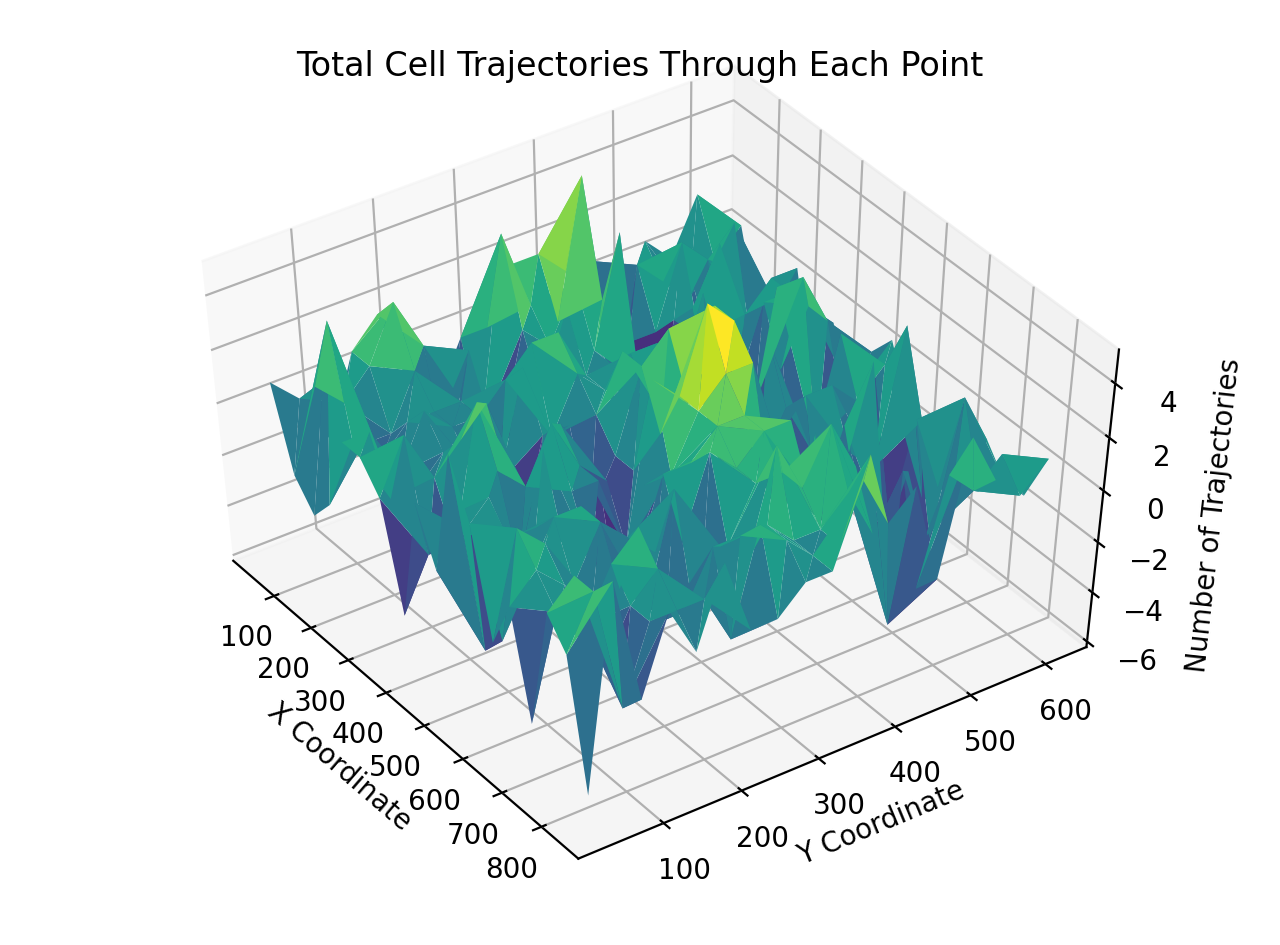

In [8]:
reload(_stat)

SIZE = 18
FRAME_SIZE = (df['POSITION_X'].max(), df['POSITION_Y'].max())

df['POSITION_X_INT'] = df['POSITION_X'].astype(int)
df['POSITION_Y_INT'] = df['POSITION_Y'].astype(int)

hieght = df.groupby(['POSITION_X_INT', 'POSITION_Y_INT', 'FRAME'], as_index=False)['TRACK_ID'].count()
hieght.columns = ['POSITION_X', 'POSITION_Y', 'FRAME', 'COUNT']
hieght.head()

x, y, z = _stat.count_rescaler(hieght, FRAME_SIZE, (SIZE, SIZE))

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (8, 6)
ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z, cmap='viridis')

ax.view_init(50, -35)
ax.dist = 11

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Number of Trajectories')
plt.title("Total Cell Trajectories Through Each Point")

In [9]:
#DISTANCE FUNCTION
def distance(x1,y1,x2,y2):
    d=np.sqrt((x1-x2)**2+(y1-y2)**2)
    return d

#CREATING IDW FUNCTION
def idw_npoint(xz,yz,n_point,p):
    r=10 #block radius iteration distance
    nf=0
    while nf<=n_point: #will stop when np reaching at least n_point
        x_block=[]
        y_block=[]
        z_block=[]
        r +=10 # add 10 unit each iteration
        xr_min=xz-r
        xr_max=xz+r
        yr_min=yz-r
        yr_max=yz+r
        for i in range(len(x)):
            # condition to test if a point is within the block
            if ((x[i]>=xr_min and x[i]<=xr_max) and (y[i]>=yr_min and y[i]<=yr_max)):
                x_block.append(x[i])
                y_block.append(y[i])
                z_block.append(z[i])
        nf=len(x_block) #calculate number of point in the block
    
    #calculate weight based on distance and p value
    w_list=[]
    for j in range(len(x_block)):
        d=distance(xz,yz,x_block[j],y_block[j])
        if d>0:
            w=1/(d**p)
            w_list.append(w)
            z0=0
        else:
            w_list.append(0) #if meet this condition, it means d<=0, weight is set to 0
    
    #check if there is 0 in weight list
    w_check=0 in w_list
    if w_check==True:
        idx=w_list.index(0) # find index for weight=0
        z_idw=z_block[idx] # set the value to the current sample value
    else:
        wt=np.transpose(w_list)
        z_idw=np.dot(z_block,wt)/sum(w_list) # idw calculation using dot product
    return z_idw


# POPULATE INTERPOLATION POINTS
n=100 #number of interpolation point for x and y axis
x_min=min(x)
x_max=max(x)
y_min=min(y)
y_max=max(y)
w=x_max-x_min #width
h=y_max-y_min #length
wn=w/n #x interval
hn=h/n #y interval

#list to store interpolation point and elevation
y_init=y_min
x_init=x_min
x_idw_list=[]
y_idw_list=[]
z_head=[]
for i in range(n):
    xz=x_init+wn*i
    yz=y_init+hn*i
    y_idw_list.append(yz)
    x_idw_list.append(xz)
    z_idw_list=[]
    for j in range(n):
        xz=x_init+wn*j
        z_idw=idw_npoint(xz,yz,5,1.5) #min. point=5, p=1.5
        z_idw_list.append(z_idw)
    z_head.append(z_idw_list)
    
print("done")

done


In [10]:
# CREATING 3D TERRAIN MODEL
fig=go.Figure()
fig.add_trace(go.Surface(z=z_head,x=x_idw_list,y=y_idw_list))
fig.update_layout(scene=dict(aspectratio=dict(x=2, y=2, z=0.5),
                             xaxis = dict(range=[x_min,x_max],),
                             yaxis = dict(range=[y_min,y_max])))

go_offline.plot(fig, 
                filename='figs/WH04_terrain_diff.html',
                validate=True, 
                auto_open=False)

'figs/WH04_terrain_diff.html'

In [11]:
fig = go.Figure(data =
    go.Contour(   
        z=z,
        x=x, # horizontal axis
        y=y, # vertical axis
        colorscale='Viridis'
    ))

fig.update_layout(
    title={
        'text': "Contour Plot Of Trajectories",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="X Coordinate",
    yaxis_title="Y Coordinate",
    legend_title="Count of Trajectories",
    showlegend=True)


go_offline.plot(fig, 
                filename='figs/WH04_contour_diff.html',
                validate=True, 
                auto_open=False)

fig.write_image("figs/WH04_contour_diff.png")